In [13]:
from datetime import date

# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
import sidetable
# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy.stats import levene
import researchpy as rp
from scipy import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=None


# 🚴 Analisis exploratorio de nuestros datos 🚴 

In [14]:
df_original = pd.read_csv("bikes_limpio2.csv", index_col=0)
df_original.head(2)

,index,date,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,1,2018-01-01,winter,0,1,1,1,2,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,winter,0,1,0,2,2,17.68695,69.6087,16.652113,131,670,801


In [15]:
df=df_original.copy()
df.reset_index(drop=True, inplace=True)
df.head(2)

,index,date,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,1,2018-01-01,winter,0,1,1,1,2,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,winter,0,1,0,2,2,17.68695,69.6087,16.652113,131,670,801


#### Eliminamos las columnas que no necesitamos

In [16]:
df.drop(["date","index"], axis=1, inplace=True)
df.head(2)

,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,winter,0,1,1,1,2,18.18125,80.5833,10.749882,331,654,985
1,winter,0,1,0,2,2,17.68695,69.6087,16.652113,131,670,801


#### Vamos a ver visualmente como está distribuida la variable respuesta

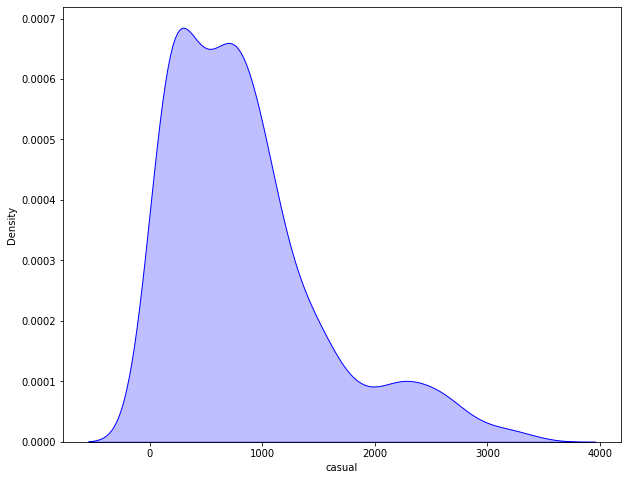

In [17]:
sns.distplot(
    df["casual"], 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

#### Vamos a ver visualmente como está distribuida las variables predictoras

#### Variables numericas

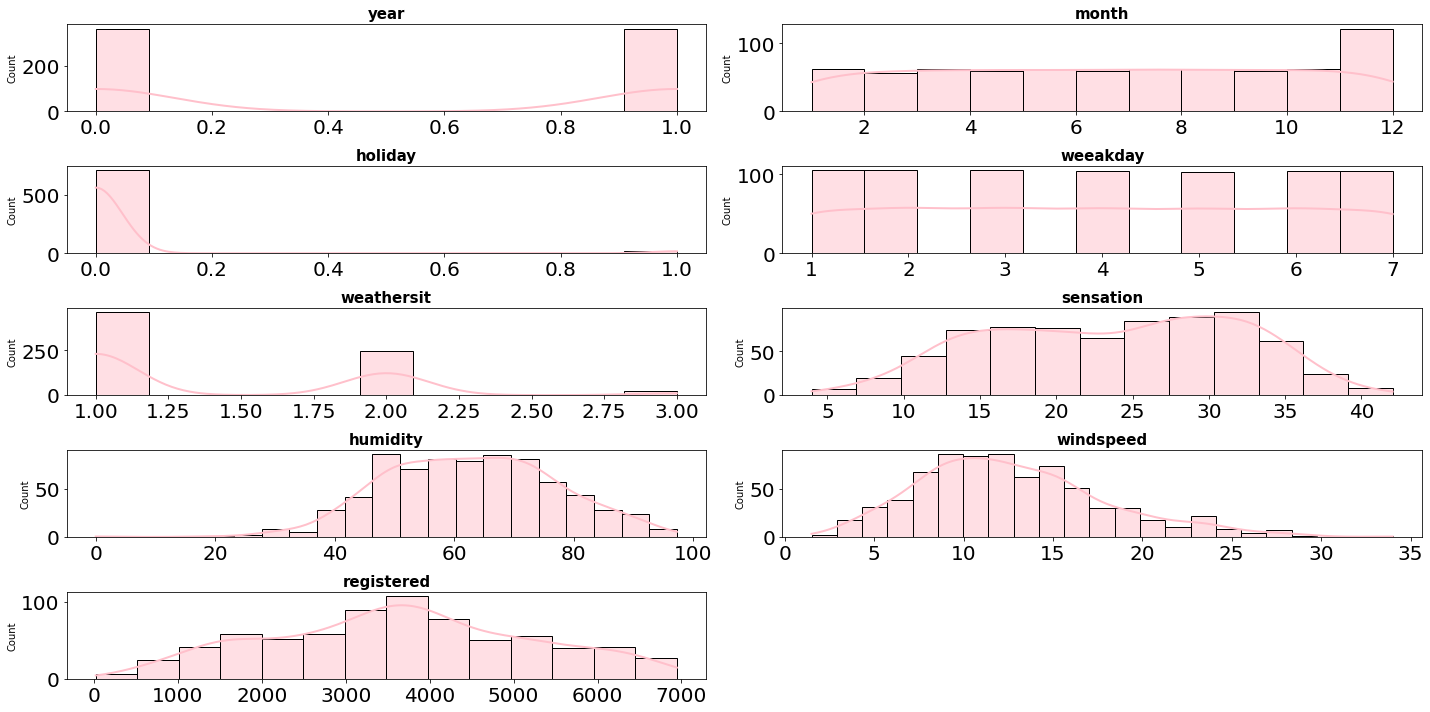

In [18]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["casual"])

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1])


Como podemos observar nuestras variables respuesta se comportan como una variable categorica, esto se debe a que algunas (year, holiday y weathersit) vienen con un encoding, pero viendo estoy resultados podemos ver que tenemos que hacer un encoding distinto ya que de no hacerlo le dariamos más peso (importancia) a valores que no queremos darle ese peso. Pero veamos como se comportan nuestras variables con respecto a nuestra variable respuesta.

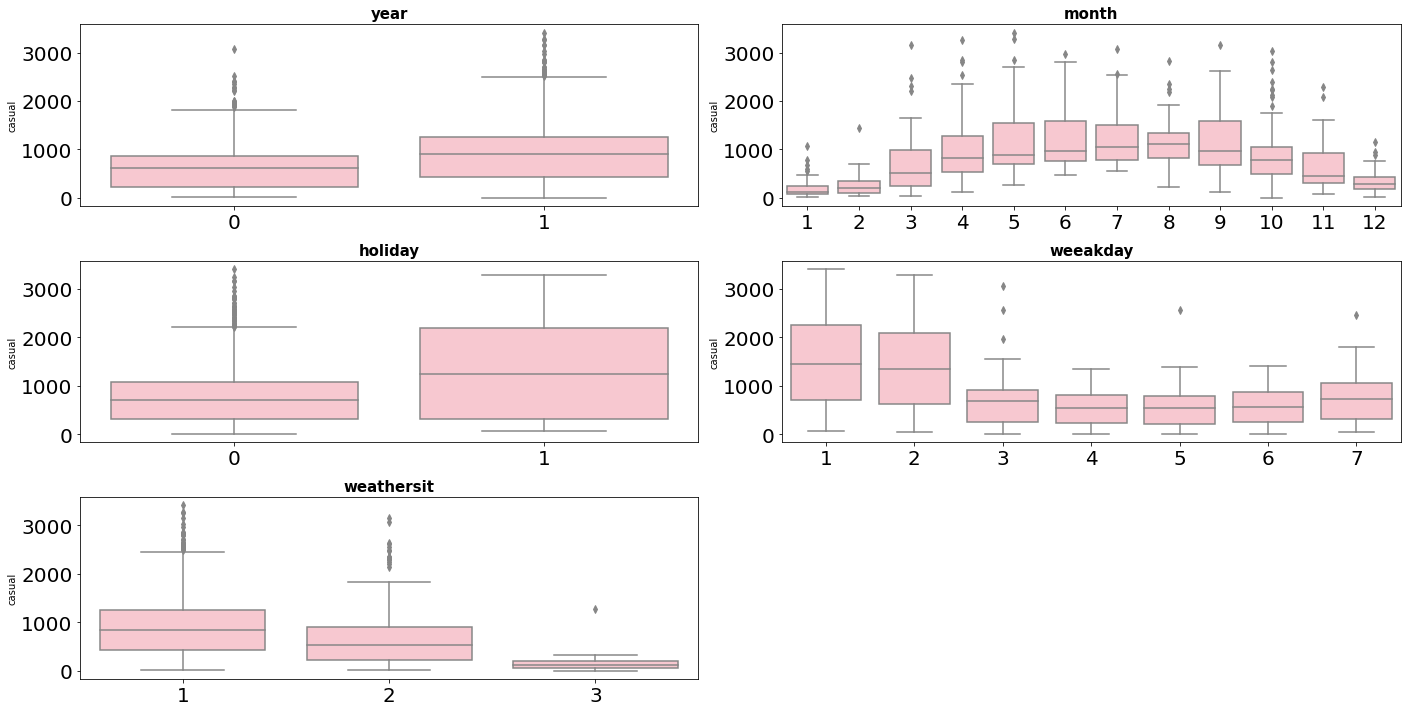

In [19]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["casual", "count","sensation", "humidity", "windspeed"])

for i, colum in enumerate(columnas_numeric): 
    sns.boxplot(
        data = df,
        y = "casual",
        x=colum,
        color = "pink", 
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1])

Resultados:
-  Year: Podemos ver que hay una variación en la median, por lo que hay que realizar encoding a la variable.

-   Month: hay variabilidad entre las mediananas por lo que tenemos que codificarlos de manera distina. 

-   Holiday: En este caso también tenemos variacion entre las medianas por lo que tendremos que realizarles encoding también.

-   Weekday: para esta variable también vemos una diferencia entre los dos primeros días de la semana, estos dos tendrán más importancia que el resto.

-   Weathersit:En esta variable vemos que los pesos están invertidos por lo que hay que codificarlo al reves.


#### Correlación entre variables numéricas

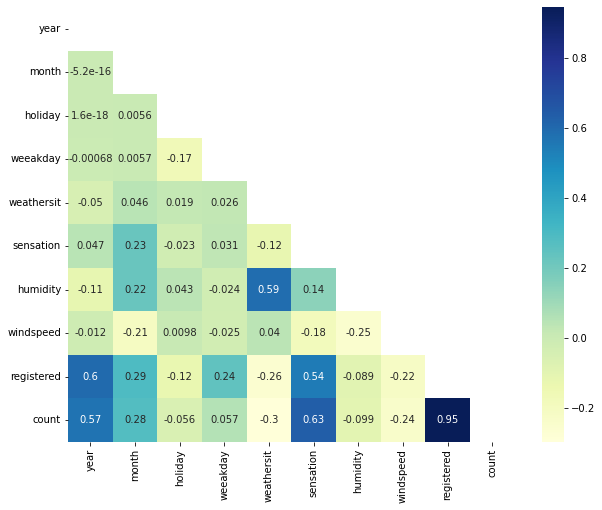

In [20]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación
numericas=df.select_dtypes(include = np.number).drop(["casual"], axis=1)

mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))

sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
            #v_min=-1,
            #v_max=1,
           annot = True);


Cómo se puede ver hay una correlación alta entre year y holiday.

# Estandarización

In [21]:
numericas.drop(["weeakday", "weathersit","month","holiday","year"], axis = 1, inplace = True)
numericas.head(2)

,sensation,humidity,windspeed,registered,count
0,18.18125,80.5833,10.749882,654,985
1,17.68695,69.6087,16.652113,670,801


In [22]:
# iniciamos el método para escalar
scaler = StandardScaler()

# ajustamos nuestros datos.  
scaler.fit(numericas)

# transformamos los datos
X_escaladas = scaler.transform(numericas)

# por último convertiremos el array que nos devuelve en un dataframe. 

numericas_estandar = pd.DataFrame(X_escaladas, columns = numericas.columns)
numericas_estandar.head(2)

,sensation,humidity,windspeed,registered,count
0,-0.680818,1.252343,-0.387833,-1.927745,-1.820972
1,-0.741507,0.480996,0.748899,-1.917480,-1.916078


In [23]:
df[numericas_estandar.columns] = numericas_estandar
df.head()

,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,winter,0,1,1,1,2,-0.680818,1.252343,-0.387833,331,-1.927745,-1.820972
1,winter,0,1,0,2,2,-0.741507,0.480996,0.748899,131,-1.917480,-1.916078
2,winter,0,1,0,3,1,-1.750344,-1.338073,0.745931,120,-1.558846,-1.632827
3,winter,0,1,0,4,1,-1.610886,-0.261577,-0.389769,108,-1.414494,-1.522732
4,winter,0,1,0,5,1,-1.505615,-1.340294,-0.046477,82,-1.373434,-1.503090


In [24]:
df.to_csv("bikes_casual.csv")